In [140]:
import numpy as np
from dotenv import load_dotenv
from dwave.system import DWaveSampler, EmbeddingComposite
from numpy import hamming
from openjij import SQASampler
import openjij
from pyqubo import Array, Constraint, LogEncInteger, solve_qubo
import math
import os
import dimod
from minorminer import find_embedding
from dwave.system import FixedEmbeddingComposite
from dwave.embedding import embed_bqm
from dwave.embedding import MinimizeEnergy
from matplotlib import pyplot as plt
import sklearn
import itertools
from copy import copy, deepcopy
import pandas as pd

In [141]:
load_dotenv()

TOKEN = os.getenv("TOKEN")
endpoint = "https://cloud.dwavesys.com/sapi/"
solver = "QA"
num_reads = 10000

In [142]:
W = 750
cost_list = [135,
             139,
             149,
             150,
             156,
             163,
             173,
             184,
             192,
             201,
             210,
             214,
             221,
             229,
             240, ]
weight_list = [70,
               73,
               77,
               80,
               82,
               87,
               90,
               94,
               98,
               106,
               110,
               113,
               115,
               118,
               120, ]
opt = [0,
0,
0,
0,
0,
0,
1,
0,
0,
0,
1,
0,
1,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
0,
1,
0,
0,
0,
0,
1,
0,
1,
0,
0,
0,
0,
1,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
0,]
N = len(cost_list)

In [143]:
x = Array.create('x', shape=(N), vartype='BINARY')
y = LogEncInteger("y", (0, W))

In [144]:
# key1 = max(cost_list, key=lambda k: cost_list[k])
max_c = max(cost_list)
B = 1
A = B * max_c * 2

In [145]:
HA = Constraint(
    A * (W - sum(weight_list[a] * x[a] for a in range(N)) - y)**2, label='HA'
)

HB = - B * sum(cost_list[a] * x[a] for a in range(N))

In [146]:
H = HA + HB
model = H.compile()
Q, offset = model.to_qubo()

In [147]:
if solver == "QA":
    dw_sampler = DWaveSampler(solver='Advantage_system6.1',
                            token=TOKEN, endpoint=endpoint)
    adj = {}
    for k in Q.keys():
        adj[k] = 1
    embedding = find_embedding(adj, dw_sampler.edgelist)
    # bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)
    sampler = FixedEmbeddingComposite(dw_sampler, embedding)
    # sampler = EmbeddingComposite(dw_sampler)
    # sampleset_embed = dw_sampler.sample(bqm_embed, num_reads=10)
    print("setting DW sampler")
else:
    sampler = SQASampler(num_reads=num_reads)
    print("setting SQA sampler")

setting DW sampler


In [148]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]

schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(schedules)


[[(0, 0), (20, 1)], [(0, 0), (5, 0.5), (15, 0.5), (20, 1)], [(0, 0), (5, 0.5), (6, 1), (20, 1)], [(0, 0), (9, 0.5), (10, 1), (20, 1)], [(0, 0), (19, 0.5), (20, 1)]]


In [149]:
def plot_schedules(t, s, save_path="output.jpg", title=None):
    linestyle = ["solid", "dotted", "dashed",
                 "dashdot", (0, (1, 10)), (0, (3, 1, 1, 1))]
    fig, ax = plt.subplots(1, len(t))
    fig.set_figwidth(5 * len(t))

    for i in range(len(t)):
        ax[i].plot(t[i], s[i])
        ax[i].set_xlim(-1.0, t[i][-1] + 1.0)
        ax[i].set_ylim(-0.1, 1.1)
        if not title == None:
            ax[i].set_title(title[i].upper())

    plt.tight_layout()
    plt.savefig(save_path)

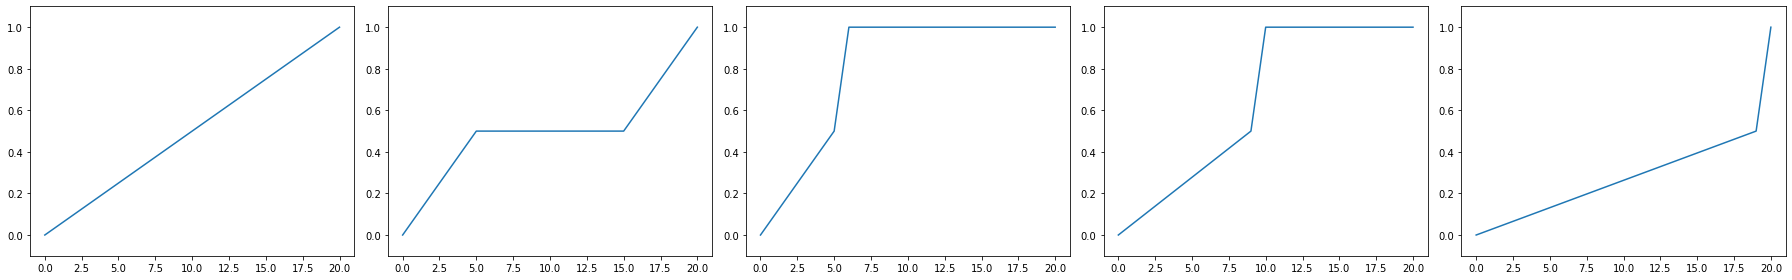

In [150]:
plot_schedules(t, s, "anneal_schedule.jpg")

In [151]:
samplesets = []
for schedule in schedules:
    print("annealing start")
    if solver == "QA":
        samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule))
    else:
        samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")

annealing start
annealing end
annealing start
annealing end
annealing start
annealing end
annealing start
annealing end
annealing start
annealing end


In [152]:
def dict_from_sampleview(sampleview):
    d = {}

    for key in sampleview.keys():
        d[key] = sampleview.get(key)
    
    return d

In [153]:
def transform_sample(sampleset, schedule, model):
    # decoded_samples = model.decode_sampleset(
    #     sampleset=sampleset, vartype="BINARY")
    decoded_samples = []
    for sample, record in zip(sampleset, sampleset.record):
        decoded_sample = model.decode_sample(
            dict_from_sampleview(sample), vartype="BINARY")
        decoded_samples.append((decoded_sample, record[1]))

    value_set = []
    for decoded_sample, energy in decoded_samples:
        cost = 0
        weight = 0
        for k in range(N):
            if decoded_sample.array('x', k) != 0:
                cost += cost_list[k]
                weight += weight_list[k]

        sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('y', elem))
                                          for elem in range(math.ceil(math.log2(W)))])

        value_set.append(
            {"cost": cost, "weight": weight, "energy": energy, "sol_y": sol_y, "broken": decoded_sample.constraints(only_broken=True)})

    value_df = pd.DataFrame(value_set)
    value_df_sorted_cost = value_df[value_df["weight"] <= W].sort_values(by=[
        "cost"])
    value_max = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmax()]
    value_min = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmin()]
    value_ave = value_df_sorted_cost["cost"].mean()

    # value_df_sorted_by_energy = value_df.sort_values(by=["energy"])

    return {"anneal_time": sampleset.info["timing"]["qpu_anneal_time_per_sample"], "anneal_schedule": schedule, "info_sets": value_set, "best_value": value_max, "average_cost": value_ave, "worst_value": value_min, "dataframe": value_df}


def v_transform_sample(samplesets, schedules, model):
    if type(samplesets) == list:
        sample_info = []
        for (sampleset, schedule) in zip(samplesets, schedules):
            sample_info.append(transform_sample(sampleset, schedule, model))
        return sample_info
    else:
        return transform_sample(transform_sample(samplesets, schedules, model))


In [154]:
def output_sample_info(sample_info):
    print("anneal time = {}".format(sample_info["anneal_time"]))
    print("anneal schedule = {}".format(sample_info["anneal_schedule"]))
    print("----- best ------")
    print("slack_Y = {}".format(sample_info["best_value"]["sol_y"]))
    print("broken: {}".format(sample_info["best_value"]["broken"]))
    print("cost : " + str(sample_info["best_value"]["cost"]))
    print("weight : " + str(sample_info["best_value"]["weight"]))
    print("-----------------")
    print("---- average -----")
    print("cost : " + str(sample_info["average_cost"]))
    print("-----------------")
    print("----- worst -----")
    print("slack_Y = {}".format(sample_info["worst_value"]["sol_y"]))
    print("broken: {}".format(sample_info["worst_value"]["broken"]))
    print("cost : " + str(sample_info["worst_value"]["cost"]))
    print("weight : " + str(sample_info["worst_value"]["weight"]))
    print("-----------------")
    print("-----describe----")
    print(sample_info["dataframe"].describe())
    print()


def v_output_sample_info(samples_info):
    if type(samples_info) == list:
        for sample_info in samples_info:
            output_sample_info(sample_info)
    else:
        output_sample_info(samples_info)


In [155]:
sample_info = v_transform_sample(samplesets, schedules, model)
v_output_sample_info(sample_info)


anneal time = 20.0
anneal schedule = [(0, 0), (20, 1)]
----- best ------
slack_Y = 26
broken: {'HA': (False, 276480.0)}
cost : 1440
weight : 748
-----------------
---- average -----
cost : 1029.7119592875317
-----------------
----- worst -----
slack_Y = 727
broken: {'HA': (False, 10231680.0)}
cost : 285
weight : 150
-----------------
-----describe----
              cost       weight        energy        sol_y
count  7885.000000  7885.000000  7.885000e+03  7885.000000
mean   1031.236398   538.045149 -2.459333e+08   436.148510
std     169.760239    88.622624  1.820557e+07   112.044322
min     285.000000   150.000000 -2.700010e+08     3.000000
25%     921.000000   479.000000 -2.599089e+08   403.000000
50%    1060.000000   552.000000 -2.480190e+08   423.000000
75%    1107.000000   576.000000 -2.382976e+08   439.000000
max    1674.000000   872.000000 -7.706265e+07   985.000000

anneal time = 20.0
anneal schedule = [(0, 0), (5, 0.5), (15, 0.5), (20, 1)]
----- best ------
slack_Y = 48
broken:

## リバースアニーリング

In [156]:
init = samplesets[0].samples()[-1]

In [157]:
t = [(0, 5, 15, 20), (0, 5, 15, 20)]
s = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]

reverse_schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(reverse_schedules)


[[(0, 1.0), (5, 0.4), (15, 0.4), (20, 1.0)], [(0, 1), (5, 0.2), (15, 0.2), (20, 1.0)]]


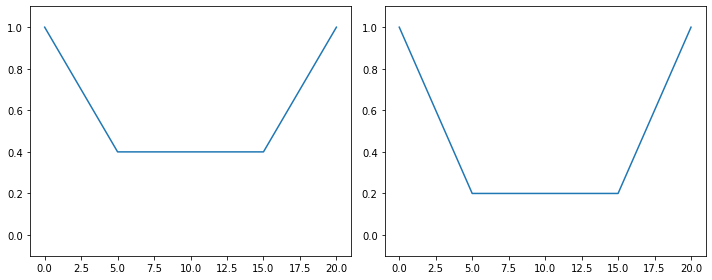

In [158]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")


In [159]:
reverse_samplesets = []
for schedule in reverse_schedules:
    print("annealing start")
    if solver == "QA":
        reverse_samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init, reinitialize_state=False))
    else:
        reverse_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


annealing start
annealing end
annealing start
annealing end


In [160]:
reverse_sample_info = v_transform_sample(reverse_samplesets, reverse_schedules, model)
v_output_sample_info(reverse_sample_info)


anneal time = 20.0
anneal schedule = [(0, 1.0), (5, 0.4), (15, 0.4), (20, 1.0)]
----- best ------
slack_Y = 279
broken: {'HA': (False, 37363680.0)}
cost : 1441
weight : 750
-----------------
---- average -----
cost : 1050.4261026826082
-----------------
----- worst -----
slack_Y = 425
broken: {'HA': (False, 14200320.0)}
cost : 289
weight : 153
-----------------
-----describe----
               cost        weight        energy         sol_y
count  10000.000000  10000.000000  1.000000e+04  10000.000000
mean    1052.634900    549.301700 -2.446770e+08    431.472000
std      166.378511     86.789249  1.806268e+07    112.720817
min      289.000000    153.000000 -2.700012e+08      1.000000
25%      921.000000    479.000000 -2.581693e+08    399.000000
50%     1073.500000    560.000000 -2.471895e+08    419.000000
75%     1191.000000    621.250000 -2.370520e+08    436.000000
max     1696.000000    881.000000 -8.963240e+07    988.000000

anneal time = 20.0
anneal schedule = [(0, 1), (5, 0.2), (15

In [161]:
for info in sample_info:
    print(info["best_value"]["cost"], "&",
          info["average_cost"], "&", info["worst_value"]["cost"], "\\\\")
for info in reverse_sample_info:
    print(info["best_value"]["cost"], "&",
          info["average_cost"], "&", info["worst_value"]["cost"], "\\\\")


1440 & 1029.7119592875317 & 285 \\
1441 & 1018.005171543895 & 221 \\
1441 & 1011.6242495585639 & 184 \\
1448 & 1019.7054924242424 & 184 \\
1442 & 1019.0351390922401 & 312 \\
1441 & 1050.4261026826082 & 289 \\
1436 & 1050.4963261197786 & 299 \\


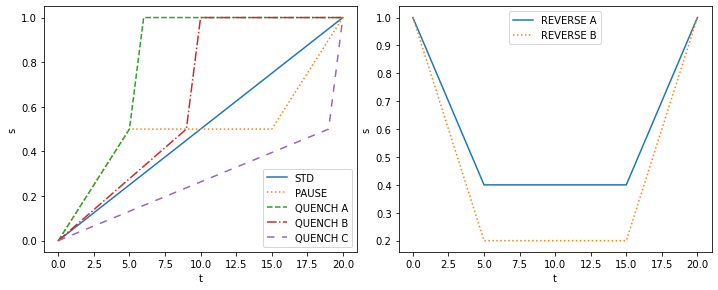

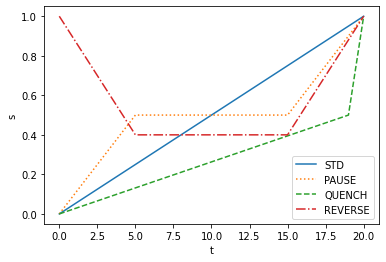

In [162]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
t2 = [(0, 5, 15, 20), (0, 5, 15, 20)]
s2 = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
t_set = [t, t2]
s_set = [s, s2]
label = [["STD", "PAUSE", "QUENCH A", "QUENCH B",
          "QUENCH C"], ["REVERSE A", "REVERSE B"]]
linestyle = ["solid", "dotted", "dashed",
             "dashdot",  (0, (5, 5)), (0, (3, 1, 1, 1))]

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.tight_layout()

for i in range(2):
    for j in range(len(t_set[i])):
        ax[i].plot(t_set[i][j], s_set[i][j], label=label[i]
                   [j], linestyle=linestyle[j])

        ax[i].set_xlabel("t")
        ax[i].set_ylabel("s")
        ax[i].legend(loc=0)
plt.savefig("fixed-anneal_schedule.jpg")


t = [(0, 20), (0, 5, 15, 20), (0, 19, 20), (0, 5, 15, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1),  (0, 0.5, 1), (1.0, 0.4, 0.4, 1.0)]
label = ["STD", "PAUSE", "QUENCH", "REVERSE"]
fig, ax = plt.subplots()

for i in range(len(t)):
    ax.plot(t[i], s[i], label=label[i], linestyle=linestyle[i])
    ax.set_xlabel("t")
    ax.set_ylabel("s")
    ax.legend(loc=0)

plt.savefig("fixed-example_schedules.jpg")


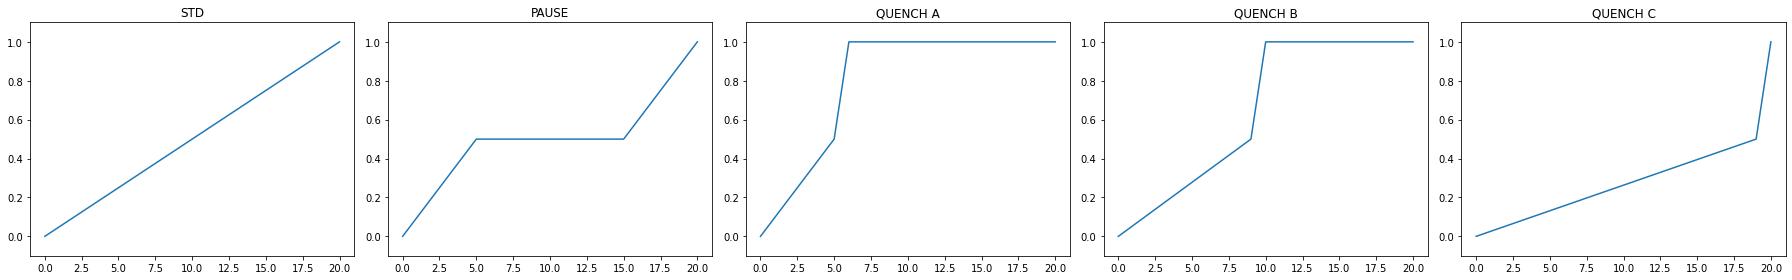

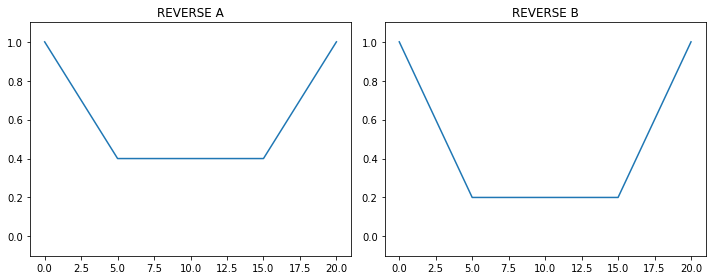

In [163]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
plot_schedules(t, s, "pause_quench_schedule.jpg", [
               "std", "pause", "quench A", "quench B", "quench C"])

t = [(0, 5, 15, 20), (0, 5, 15, 20)]
s = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
plot_schedules(t, s, "reverse_anneal.jpg", [
               "reverse A", "reverse B"])
